In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.optimizers import Adam
from keras.models import Model
from keras import regularizers
import keras.backend as K
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm
from itertools import product
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn

%matplotlib inline

Using TensorFlow backend.


In [2]:
data = pd.read_csv(r'../../output/metrics.csv')
df = pd.DataFrame(data)
df['title'] = df['level_0']
attack_series = []
attack_IDs = []
dimensions_series = []
for _, row in df.iterrows():
    attack_series.append(row['level_1'].split('/')[-2])

df['attack'] = attack_series

for _, row in df.iterrows():
    dimension = int(row['attack'].split('_')[0].replace('p',''))
    dimensions_series.append(dimension)
    if row['attack'] in ['1080p', '720p', '480p', '360p', '240p', '144p']:
            attack_IDs.append(1)
    else:
        attack_IDs.append(0)

df['attack_ID'] = attack_IDs
df['dimension'] = dimensions_series
df = df.drop(['Unnamed: 0',
         'temporal_canny-series',
         'temporal_cross_correlation-series', 
         'temporal_difference-series', 
         'temporal_histogram_distance-series', 
         'temporal_histogram_distance-cosine',
         'level_0', 
#           'dimension',
#           'temporal_canny-cosine',
#           'temporal_cross_correlation-cosine',
#               'temporal_difference-cosine',
         'level_1'],axis=1)

In [3]:
df.head(5)

,temporal_canny-cosine,temporal_canny-euclidean,temporal_cross_correlation-cosine,temporal_cross_correlation-euclidean,temporal_difference-cosine,temporal_difference-euclidean,temporal_histogram_distance-euclidean,vmaf,title,attack,attack_ID,dimension
0,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,NaN,../../data/1080p/-8ygLPzgpsg.mp4,1080p,1,1080
1,0.000566,0.670932,7.154334e-07,0.186423,0.000021,0.585142,0.587441,78.516691,../../data/1080p/-8ygLPzgpsg.mp4,1080p_watermark,0,1080
2,0.001139,1.866004,5.874493e-04,3.274284,0.000036,0.361467,0.048735,3.019776,../../data/1080p/-8ygLPzgpsg.mp4,1080p_flip_vertical,0,1080
3,0.001072,1.812684,8.232710e-04,4.191308,0.000043,0.403333,0.091211,1.929483,../../data/1080p/-8ygLPzgpsg.mp4,1080p_rotate_90_clockwise,0,1080
4,0.000633,0.630162,8.913559e-07,0.385323,0.000296,1.154801,11.787850,NaN,../../data/1080p/-8ygLPzgpsg.mp4,1080p_vignette,0,1080


In [4]:
df.describe()

,temporal_canny-cosine,temporal_canny-euclidean,temporal_cross_correlation-cosine,temporal_cross_correlation-euclidean,temporal_difference-cosine,temporal_difference-euclidean,temporal_histogram_distance-euclidean,vmaf,attack_ID,dimension
count,5796.000000,5796.000000,5.796000e+03,5796.000000,5796.000000,5796.000000,5796.000000,3174.000000,5796.000000,5796.000000
mean,0.124845,12196.617817,2.942489e-03,1.671773,0.021534,3.302123,5.355903,40.343494,0.142857,504.000000
std,0.246705,50237.227818,1.237253e-02,2.582384,0.070417,2.904630,9.728277,40.267544,0.349957,316.001944
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,144.000000
25%,0.000873,1.099166,3.474633e-07,0.103534,0.000725,1.348963,0.165798,1.475565,0.000000,240.000000
50%,0.003933,3.552987,4.852876e-06,0.352134,0.003272,2.496744,0.604480,9.992767,0.000000,420.000000
75%,0.090100,12.470781,3.877885e-04,2.447800,0.013115,4.241309,5.357450,84.832563,0.000000,720.000000
max,0.974069,378978.958427,1.665425e-01,12.605094,0.823593,22.774383,56.174166,99.590587,1.000000,1080.000000


In [5]:
df_corr = df.corr()
plt.figure(figsize=(10,10))
corr = df_corr.corr('spearman')
corr.style.background_gradient().set_precision(2)

,temporal_canny-cosine,temporal_canny-euclidean,temporal_cross_correlation-cosine,temporal_cross_correlation-euclidean,temporal_difference-cosine,temporal_difference-euclidean,temporal_histogram_distance-euclidean,vmaf,attack_ID,dimension
temporal_canny-cosine,1,0.88,0.42,0.49,0.48,0.079,0.091,-0.35,-0.16,-0.079
temporal_canny-euclidean,0.88,1,0.22,0.41,0.59,0.13,0.079,-0.24,-0.14,-0.19
temporal_cross_correlation-cosine,0.42,0.22,1,0.92,-0.33,-0.62,-0.7,-0.94,-0.28,0.56
temporal_cross_correlation-euclidean,0.49,0.41,0.92,1,-0.16,-0.43,-0.54,-0.95,-0.49,0.36
temporal_difference-cosine,0.48,0.59,-0.33,-0.16,1,0.73,0.47,0.36,0.055,-0.73
temporal_difference-euclidean,0.079,0.13,-0.62,-0.43,0.73,1,0.73,0.55,-0.2,-0.94
temporal_histogram_distance-euclidean,0.091,0.079,-0.7,-0.54,0.47,0.73,1,0.59,-0.067,-0.7
vmaf,-0.35,-0.24,-0.94,-0.95,0.36,0.55,0.59,1,0.47,-0.45
attack_ID,-0.16,-0.14,-0.28,-0.49,0.055,-0.2,-0.067,0.47,1,0.28
dimension,-0.079,-0.19,0.56,0.36,-0.73,-0.94,-0.7,-0.45,0.28,1


<Figure size 720x720 with 0 Axes>

In [6]:
train_prop = 0.8

df_1 = df[df['attack_ID'] == 1]
df_0 = df[df['attack_ID'] == 0]


num_train = int(df_1.shape[0]*0.8)
df_train = df_1[0:num_train]
df_test = df_1[num_train:]
df_attacks = df_0

df_train = df_train.sample(frac=1)
df_test = df_test.sample(frac=1)
df_attacks = df_attacks.sample(frac=1)

X_train = df_train.drop(['title',
                         'attack', 
                         'attack_ID',
                         'dimension',
                         'vmaf'],axis=1)
X_train = np.asarray(X_train)

X_test = df_test.drop(['title',  
                     'attack', 
                     'attack_ID',
                     'dimension',  
                     'vmaf'],axis=1)
X_test = np.asarray(X_test)

X_attacks = df_attacks.drop(['title',  
                     'attack', 
                     'attack_ID',
                     'dimension',
                     'vmaf'],axis=1)

X_attacks = np.asarray(X_attacks)

print('Shape of train: {}'.format(X_train.shape))
print('Shape of test: {}'.format(X_test.shape))
print('Shape of attacks: {}'.format(X_attacks.shape))


Shape of train: (662, 7)
Shape of test: (166, 7)
Shape of attacks: (4968, 7)


Text(0, 0.5, 'Explained variance')

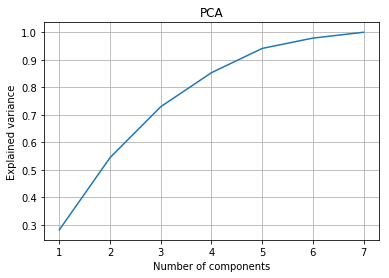

In [7]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

x_train = ss.fit_transform(X_train)
x_test = ss.transform(X_test)
x_attacks = ss.transform(X_attacks)

variances = []
components = reversed(range(1,x_test.shape[1]+1))
for i in components:
    pca = PCA(n_components=i)
    pca.fit(x_train)
    variances.append(sum(pca.explained_variance_ratio_))
plt.plot(list(reversed(range(1,x_test.shape[1]+1))), variances)   
plt.grid()
plt.title('PCA')
plt.xlabel('Number of components')
plt.ylabel('Explained variance')

In [8]:
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(x_train)
test_reduced = pca.transform(x_test)
attack_reduced = pca.transform(x_attacks)


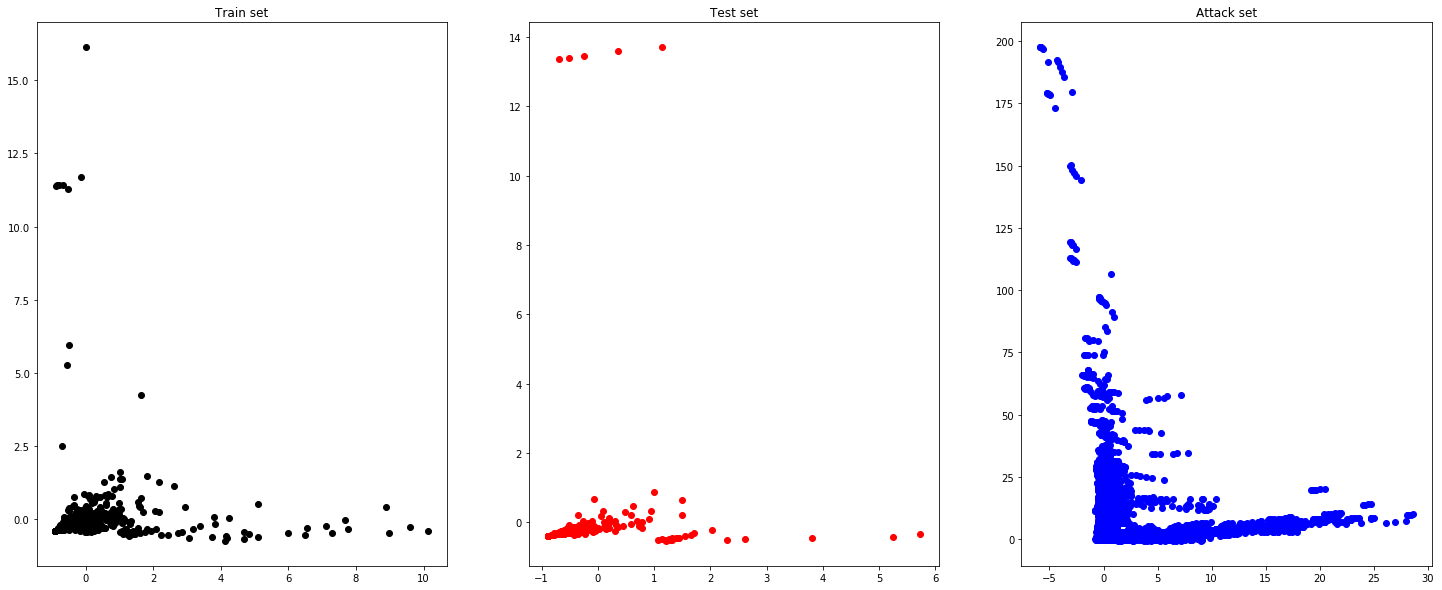

In [9]:
f, ax = plt.subplots(1,3, figsize=(25,10))
ax[0].set_title("Train set")
ax[1].set_title("Test set")
ax[2].set_title("Attack set")
ax[0].scatter(X_reduced[:,0], X_reduced[:,1], color='black')
ax[1].scatter(test_reduced[:,0], test_reduced[:,1], color='red')
ax[2].scatter(attack_reduced[:,0], attack_reduced[:,1], color='blue')

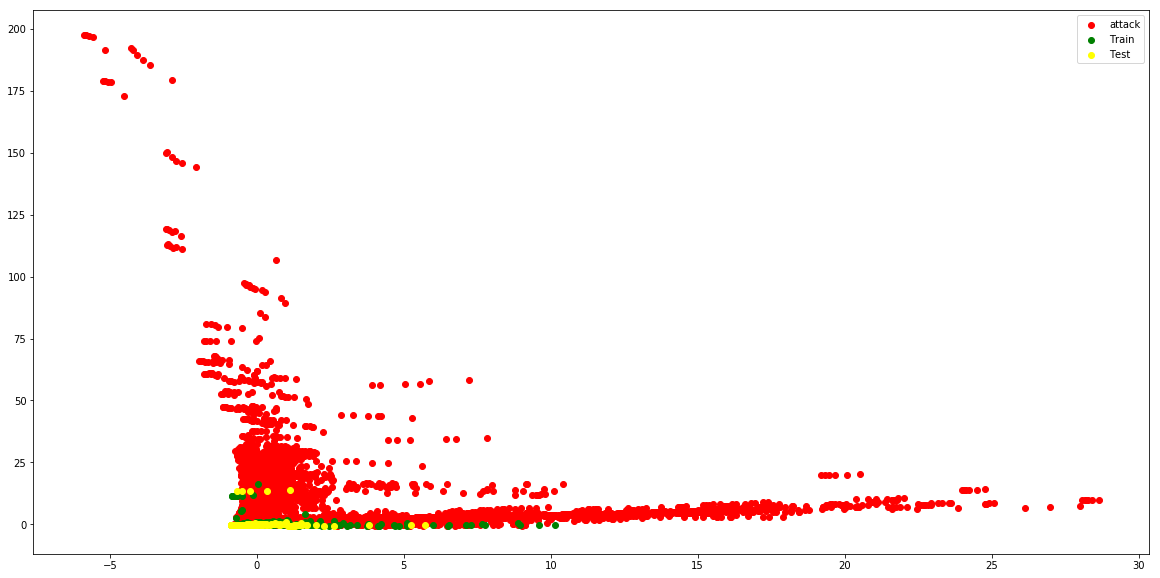

In [10]:
plt.figure(figsize=(20,10))
plt.scatter(attack_reduced[:,0], attack_reduced[:,1], color='red', label='attack')
plt.scatter(X_reduced[:,0], X_reduced[:,1], color='green', label='Train')
plt.scatter(test_reduced[:,0], test_reduced[:,1], color='yellow', label='Test')
plt.legend()


# One Class SVM

In [11]:
from sklearn import metrics 

nus = [0.1, 0.01, 0.001, 0.0001]

svm_results = pd.DataFrame(columns=['gamma', 'nu', 'n_components', 'train_acc', 
                                    'test_acc', 'attack_acc', 'model', 'auc', 'f_beta'])
for n in reversed(range(1,x_test.shape[1]+1)):
    pca = PCA(n_components=n)
    X_reduced = pca.fit_transform(x_train)
    test_reduced = pca.transform(x_test)
    attack_reduced = pca.transform(x_attacks)

    gammas = [X_reduced.shape[1], 2*X_reduced.shape[1], X_reduced.shape[1]/2, 'auto']                                 
    for nu in nus:
        for gamma in gammas:
            classifier = svm.OneClassSVM(kernel='rbf',gamma=gamma, nu=nu, cache_size=5000)
            classifier.fit(X_reduced)
            y_pred_train = classifier.predict(X_reduced)
            y_pred_test = classifier.predict(test_reduced)
            y_pred_outliers = classifier.predict(attack_reduced)
            n_accurate_train = y_pred_train[y_pred_train == 1].size
            n_accurate_test = y_pred_test[y_pred_test == 1].size
            n_accurate_outliers = y_pred_outliers[y_pred_outliers == -1].size
            
            
            fpr, tpr, _ = metrics.roc_curve(np.concatenate([np.ones(y_pred_test.shape[0]),
                                                             -1*np.ones(y_pred_outliers.shape[0])]), 
                                              np.concatenate([y_pred_test, y_pred_outliers]) , pos_label=1)
            fb = metrics.fbeta_score(np.concatenate([np.ones(y_pred_test.shape[0]),
                                                             -1*np.ones(y_pred_outliers.shape[0])]), 
                                              np.concatenate([y_pred_test, y_pred_outliers]),beta=20 ,pos_label=1)
            
            svm_results = svm_results.append({'nu': nu, 'gamma': gamma, 'n_components': n, 'train_acc': n_accurate_train/X_reduced.shape[0],
                           'test_acc': n_accurate_train/X_reduced.shape[0], 'attack_acc': n_accurate_outliers/attack_reduced.shape[0],
                           'model': 'svm', 'auc': metrics.auc(fpr, tpr), 'f_beta': fb}, ignore_index=True)


/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [12]:
svm_results.sort_values('f_beta', ascending=False).head(10)

,gamma,nu,n_components,train_acc,test_acc,attack_acc,model,auc,f_beta
90,1,0.0010,2,0.968278,0.968278,0.689211,svm,0.823521,0.936214
88,2,0.0010,2,0.945619,0.945619,0.721618,svm,0.830689,0.920767
84,2,0.0100,2,0.957704,0.957704,0.715378,svm,0.824557,0.914461
106,0.5,0.0010,1,0.942598,0.942598,0.313003,svm,0.635417,0.911207
59,auto,0.0010,4,0.963746,0.963746,0.717995,svm,0.822853,0.908748
75,auto,0.0010,3,0.971299,0.971299,0.704509,svm,0.816110,0.907853
85,4,0.0100,2,0.938066,0.938066,0.767713,svm,0.844700,0.906154
7,auto,0.0100,7,0.975831,0.975831,0.734098,svm,0.827892,0.903925
31,auto,0.0001,6,0.950151,0.950151,0.728663,svm,0.825175,0.903565
55,auto,0.0100,4,0.965257,0.965257,0.716787,svm,0.819237,0.902781


In [13]:
svm_results.sort_values('auc', ascending=False).head(20)

,gamma,nu,n_components,train_acc,test_acc,attack_acc,model,auc,f_beta
50,2,0.1000,4,0.886707,0.886707,0.847826,svm,0.851624,0.846117
85,4,0.0100,2,0.938066,0.938066,0.767713,svm,0.844700,0.906154
93,4,0.0001,2,0.802115,0.802115,0.856280,svm,0.843803,0.822845
38,2.5,0.0100,5,0.880665,0.880665,0.891908,svm,0.843544,0.789217
81,4,0.1000,2,0.901813,0.901813,0.775966,svm,0.842802,0.894878
89,4,0.0010,2,0.915408,0.915408,0.785829,svm,0.841710,0.883691
48,4,0.1000,4,0.864048,0.864048,0.887279,svm,0.835206,0.777016
88,2,0.0010,2,0.945619,0.945619,0.721618,svm,0.830689,0.920767
42,2.5,0.0010,5,0.827795,0.827795,0.894726,svm,0.829893,0.759538
43,auto,0.0010,5,0.962236,0.962236,0.743760,svm,0.829711,0.898666


In [14]:
# Let's create a metric in order to find a best model from that metric
# We will get just accuracies from test y attack above 0.7, and will add them

In [15]:
def metric(row, th=0.7):
    if row['test_acc'] < th or row['attack_acc'] < th:
        return 0
    else:
        return row['test_acc'] + row['attack_acc']

In [16]:
svm_results['score'] = svm_results.apply(metric, axis=1)

In [17]:
svm_results[svm_results['test_acc'] > svm_results['attack_acc']].sort_values('score', ascending=False).head(10)

,gamma,nu,n_components,train_acc,test_acc,attack_acc,model,auc,f_beta,score
65,6,0.100,3,0.898792,0.898792,0.844404,svm,0.822805,0.792396,1.743196
50,2,0.100,4,0.886707,0.886707,0.847826,svm,0.851624,0.846117,1.734533
70,1.5,0.010,3,0.942598,0.942598,0.769928,svm,0.818699,0.853103,1.712526
7,auto,0.010,7,0.975831,0.975831,0.734098,svm,0.827892,0.903925,1.709929
39,auto,0.010,5,0.966767,0.966767,0.742955,svm,0.826297,0.892714,1.709722
68,3,0.010,3,0.907855,0.907855,0.799517,svm,0.818433,0.825335,1.707372
43,auto,0.001,5,0.962236,0.962236,0.743760,svm,0.829711,0.898666,1.705996
85,4,0.010,2,0.938066,0.938066,0.767713,svm,0.844700,0.906154,1.705780
89,4,0.001,2,0.915408,0.915408,0.785829,svm,0.841710,0.883691,1.701237
27,auto,0.001,6,0.960725,0.960725,0.738929,svm,0.824284,0.892451,1.699654


# Isolation Forest

In [18]:
from sklearn.ensemble import IsolationForest

estimators = [50, 100, 150, 200, 500]
contaminations = [0.01, 0.1]
isolation_results = pd.DataFrame(columns=['estimators', 'contamination', 'n_components', 'max_features',
                                          'test_acc', 'attack_acc', 'model', 'auc', 'f_beta'])
for n in reversed(range(1,x_test.shape[1]+1)):
    pca = PCA(n_components=n)
    X_reduced = pca.fit_transform(x_train)
    test_reduced = pca.transform(x_test)
    attack_reduced = pca.transform(x_attacks)
    max_features = list(range(1, n + 1))
    for estimator in estimators:
        for contamination in contaminations:
            for max_feature in max_features:
                classifier = IsolationForest(n_estimators=estimator,
                                             contamination=contamination,
                                             max_features=max_feature,
                                            n_jobs=5)
                
                classifier.fit(X_reduced)
                y_pred_train = classifier.predict(X_reduced)
                y_pred_test = classifier.predict(test_reduced)
                y_pred_outliers = classifier.predict(attack_reduced)
                n_error_train = y_pred_train[y_pred_train == 1].size
                n_error_test = y_pred_test[y_pred_test == 1].size
                n_error_outliers = y_pred_outliers[y_pred_outliers == -1].size
                
                fpr, tpr, _ = metrics.roc_curve(np.concatenate([np.ones(y_pred_test.shape[0]),
                                                 -1*np.ones(y_pred_outliers.shape[0])]), 
                                  np.concatenate([y_pred_test, y_pred_outliers]) , pos_label=1)
                
                fb = metrics.fbeta_score(np.concatenate([np.ones(y_pred_test.shape[0]),
                                                             -1*np.ones(y_pred_outliers.shape[0])]), 
                                              np.concatenate([y_pred_test, y_pred_outliers]),beta=20 ,pos_label=1)

                isolation_results = isolation_results.append({'estimators': estimator, 'contamination': contamination,
                                                              'n_components': n, 'max_features': max_feature,
                                                              'train_acc': n_error_train/X_reduced.shape[0],
                                                              'test_acc': n_error_train/X_reduced.shape[0],
                                                              'attack_acc': n_error_outliers/attack_reduced.shape[0],
                                                              'model': 'isolation_forest',
                                                              'auc': metrics.auc(fpr, tpr),
                                                              'f_beta': fb}, ignore_index=True)

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", De

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", De

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", De

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", De

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", De

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", De

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", De

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", De

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", De

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", De

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", De

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", De

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", De

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", De

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", De

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", De

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", De

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", De

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", De

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", De

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", De

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", De

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", De

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", De

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", De

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", De

In [19]:
isolation_results['score'] = isolation_results.apply(metric, axis=1)

In [20]:
isolation_results[isolation_results['test_acc'] > isolation_results['attack_acc']].sort_values('test_acc', ascending=False).head(10)

,estimators,contamination,n_components,max_features,test_acc,attack_acc,model,auc,f_beta,train_acc,score
0,50,0.01,7,1,0.989426,0.446457,isolation_forest,0.723229,0.960327,0.989426,0.0
162,200,0.01,5,3,0.989426,0.388688,isolation_forest,0.694344,0.956367,0.989426,0.0
143,100,0.01,5,4,0.989426,0.451691,isolation_forest,0.722833,0.954913,0.989426,0.0
144,100,0.01,5,5,0.989426,0.481884,isolation_forest,0.737930,0.956985,0.989426,0.0
150,150,0.01,5,1,0.989426,0.375403,isolation_forest,0.687701,0.955461,0.989426,0.0
151,150,0.01,5,2,0.989426,0.388688,isolation_forest,0.694344,0.956367,0.989426,0.0
152,150,0.01,5,3,0.989426,0.413446,isolation_forest,0.706723,0.958060,0.989426,0.0
153,150,0.01,5,4,0.989426,0.457729,isolation_forest,0.728865,0.961103,0.989426,0.0
154,150,0.01,5,5,0.989426,0.445652,isolation_forest,0.722826,0.960271,0.989426,0.0
160,200,0.01,5,1,0.989426,0.375604,isolation_forest,0.687802,0.955475,0.989426,0.0


In [21]:
isolation_results.sort_values('f_beta', ascending=False).head(10)

,estimators,contamination,n_components,max_features,test_acc,attack_acc,model,auc,f_beta,train_acc,score
1,50,0.01,7,2,0.989426,0.583535,isolation_forest,0.791767,0.969855,0.989426,0.0
6,50,0.01,7,7,0.989426,0.571055,isolation_forest,0.785527,0.968980,0.989426,0.0
18,100,0.01,7,5,0.989426,0.536634,isolation_forest,0.768317,0.966574,0.989426,0.0
60,500,0.01,7,5,0.989426,0.528382,isolation_forest,0.764191,0.965999,0.989426,0.0
5,50,0.01,7,6,0.989426,0.485507,isolation_forest,0.742754,0.963022,0.989426,0.0
191,100,0.01,4,4,0.989426,0.479066,isolation_forest,0.739533,0.962576,0.989426,0.0
123,500,0.01,6,6,0.989426,0.473430,isolation_forest,0.736715,0.962187,0.989426,0.0
163,200,0.01,5,4,0.989426,0.472222,isolation_forest,0.736111,0.962103,0.989426,0.0
34,150,0.01,7,7,0.989426,0.548510,isolation_forest,0.771243,0.961589,0.989426,0.0
59,500,0.01,7,4,0.989426,0.546498,isolation_forest,0.770237,0.961449,0.989426,0.0


# Let's plot ROCs

In [22]:
def plot_roc(fpr, tpr, title):
    roc_auc = metrics.auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
            lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: {}'.format(title))
    plt.legend(loc="lower right")
    plt.show()

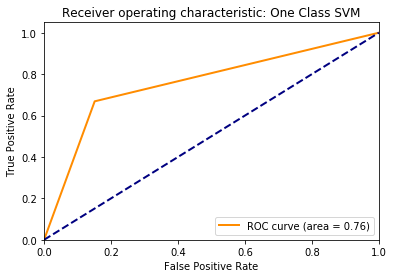

In [23]:
pca = PCA(n_components=4)
X_reduced = pca.fit_transform(x_train)
test_reduced = pca.transform(x_test)
attack_reduced = pca.transform(x_attacks)


classifier = svm.OneClassSVM(kernel='rbf',gamma=2, nu=0.001, cache_size=5000)
classifier.fit(X_reduced)
y_pred_train = classifier.predict(X_reduced)
y_pred_test = classifier.predict(test_reduced)
y_pred_outliers = classifier.predict(attack_reduced)
n_accurate_train = y_pred_train[y_pred_train == 1].size
n_accurate_test = y_pred_test[y_pred_test == 1].size
n_accurate_outliers = y_pred_outliers[y_pred_outliers == -1].size

fpr, tpr, _ = metrics.roc_curve(np.concatenate([np.ones(y_pred_test.shape[0]),
                                                 -1*np.ones(y_pred_outliers.shape[0])]), 
                                  np.concatenate([y_pred_test, y_pred_outliers]) , pos_label=1)

plot_roc(fpr, tpr, 'One Class SVM')

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", De

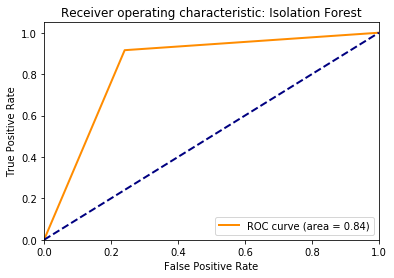

In [24]:
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(x_train)
test_reduced = pca.transform(x_test)
attack_reduced = pca.transform(x_attacks)


classifier = IsolationForest(n_estimators=500,
                            contamination=0.1,
                            max_features=2,
                            n_jobs=5)
classifier.fit(X_reduced)
y_pred_train = classifier.predict(X_reduced)
y_pred_test = classifier.predict(test_reduced)
y_pred_outliers = classifier.predict(attack_reduced)
n_accurate_train = y_pred_train[y_pred_train == 1].size
n_accurate_test = y_pred_test[y_pred_test == 1].size
n_accurate_outliers = y_pred_outliers[y_pred_outliers == -1].size

fpr, tpr, _ = metrics.roc_curve(np.concatenate([np.ones(y_pred_test.shape[0]),
                                                 -1*np.ones(y_pred_outliers.shape[0])]), 
                                  np.concatenate([y_pred_test, y_pred_outliers]) , pos_label=1)

plot_roc(fpr, tpr, 'Isolation Forest')

In [87]:
best_svm = svm_results.sort_values('f_beta', ascending=False).iloc[0]
pca = PCA(n_components=best_svm['n_components'])
X_reduced = pca.fit_transform(x_train)
test_reduced = pca.transform(x_test)
attack_reduced = pca.transform(x_attacks)
classifier = svm.OneClassSVM(kernel='rbf',gamma=best_svm['gamma'], nu=best_svm['nu'], cache_size=5000,  tol=0.1)
classifier.fit(X_reduced)

OneClassSVM(cache_size=5000, coef0=0.0, degree=3, gamma=1.0, kernel='rbf',
      max_iter=-1, nu=0.001, random_state=None, shrinking=True, tol=0.1,
      verbose=False)

In [88]:
y_pred_outliers = classifier.predict(attack_reduced)

In [89]:
df_attacks_reset = df_attacks.reset_index()

accurate_outliers_df = pd.DataFrame(y_pred_outliers, columns=['pred']) 
undetected = df_attacks_reset[accurate_outliers_df['pred'] == 1][['attack', 'title', 'dimension']]


In [90]:
undetected.groupby(['dimension', 'attack']).count()

,,title
dimension,attack,


In [91]:
undetected.groupby('title').count().sort_values(['attack'], ascending=False)

,attack,dimension
title,,


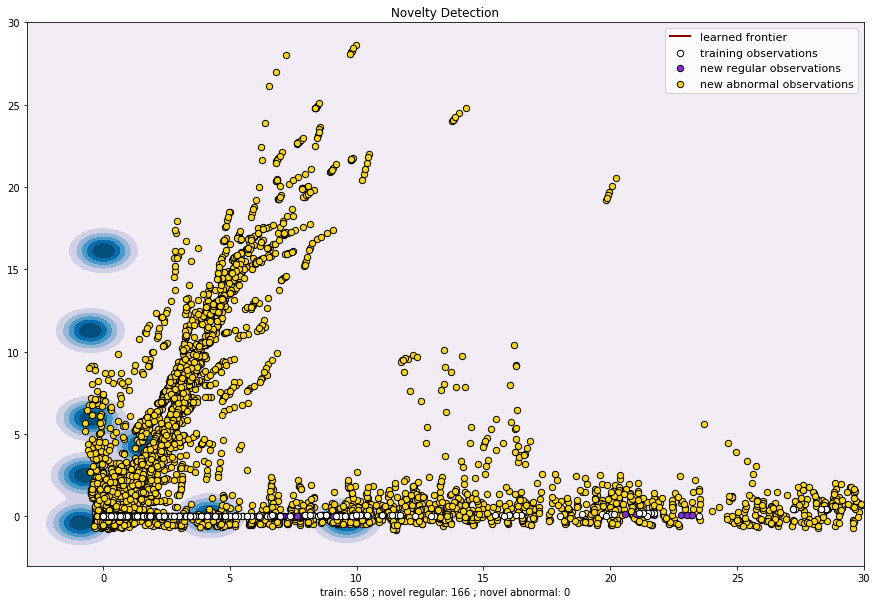

In [92]:
import matplotlib.font_manager

xx, yy = np.meshgrid(np.linspace(-3, 30, 500), np.linspace(-3, 30, 500))

y_pred_train = classifier.predict(X_reduced)
y_pred_test = classifier.predict(test_reduced)
y_pred_outliers = classifier.predict(attack_reduced)
n_error_train = y_pred_train[y_pred_train == -1].size
n_error_test = y_pred_test[y_pred_test == -1].size
n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size

# plot the line, the points, and the nearest vectors to the plane
Z = classifier.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(15,10))
plt.title("Novelty Detection")
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred')

s = 40
c = plt.scatter(attack_reduced[:, 1], attack_reduced[:, 0], c='gold', s=s,
                edgecolors='k')
b2 = plt.scatter(X_test[:, 1], X_test[:, 0], c='blueviolet', s=s,
                 edgecolors='k')

b1 = plt.scatter(X_train[:, 1], X_train[:, 0], c='white', s=s, edgecolors='k')

plt.axis('tight')
plt.xlim((-3, 30))
plt.ylim((-3, 30))
plt.legend([a.collections[0], b1, b2, c],
           ["learned frontier", "training observations",
            "new regular observations", "new abnormal observations"],
           loc="upper right",
           prop=matplotlib.font_manager.FontProperties(size=11))
plt.xlabel(
    "train: %d ; novel regular: %d ; "
    "novel abnormal: %d"
    % (n_error_train, n_error_test, n_error_outliers))
plt.show()

# Conclusions

After the analysis made with the results of the best SVM, we have reached some interesting results:
* The attacks that pass through the system belong to the same attacks: watermarks and low bitrate
* The attacks that pass through the network do not belong to the same resolution

This means that we might be able to generalize into other attacks and resolutions

# Autoencoder

In [30]:
latent_dim = 14
input_vector = Input(shape=(X_train.shape[1],))
encoded = Dense(latent_dim, activation='relu')(input_vector)
decoded = Dense(X_train.shape[1], activity_regularizer=regularizers.l1(10e-5))(encoded)
autoencoder = Model(input_vector, decoded)
encoder = Model(input_vector, encoded)
autoencoder.compile(optimizer=Adam(lr=0.001), loss='mse')
network_history = autoencoder.fit(x_train, x_train, shuffle=True, batch_size=8, epochs=1000,
                                  validation_data=(x_test, x_test), verbose=False)


In [31]:
def plot_history(network_history,title='Autoencoder Loss'):
    plt.figure(figsize=(10,5))
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])
    plt.show()

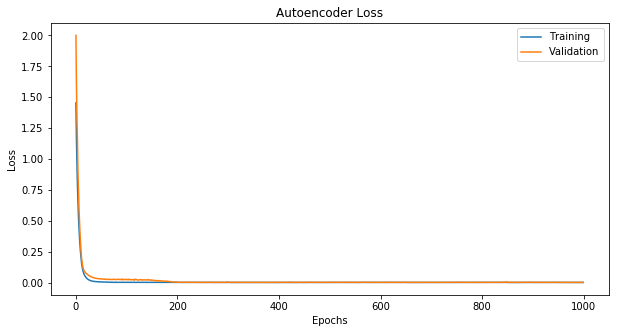

In [32]:
plot_history(network_history)

In [33]:
print('Mean loss on train: {}'.format(autoencoder.evaluate(x_train, x_train, batch_size=8, verbose=False)))
print('Mean loss on test: {}'.format(autoencoder.evaluate(x_test, x_test, batch_size=8, verbose=False)))
print('Mean loss on attacks: {}'.format(autoencoder.evaluate(x_attacks, x_attacks, batch_size=8, verbose=False)))

Mean loss on train: 0.0027738501011109785
Mean loss on test: 0.0033301408051973186
Mean loss on attacks: 7.4621723787319185


In [34]:
x_train_pred = autoencoder.predict(x_train, batch_size=8)
x_test_pred = autoencoder.predict(x_test, batch_size=8)
x_attacks_pred = autoencoder.predict(x_attacks, batch_size=8)

/home/ignacio/Projects/livepeer/env/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


(0, 5)

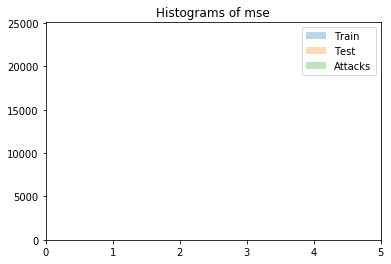

In [35]:
mse_train = (((x_train - x_train_pred)**2).mean(axis=1))
mse_test = (((x_test - x_test_pred)**2).mean(axis=1))
mse_attacks = (((x_attacks - x_attacks_pred)**2).mean(axis=1))

plt.figure()
kwargs = dict(histtype='stepfilled', alpha=0.3, normed=True, bins=200)

plt.hist(mse_train, **kwargs)
plt.hist(mse_test, **kwargs)
plt.hist(mse_attacks, **kwargs)
plt.legend(['Train', 'Test', 'Attacks'])
plt.title('Histograms of mse')
plt.xlim([0, 5])


In [36]:
x_train_red = encoder.predict(x_train, batch_size=8)
x_test_red = encoder.predict(x_test, batch_size=8)
x_attacks_red = encoder.predict(x_attacks, batch_size=8)

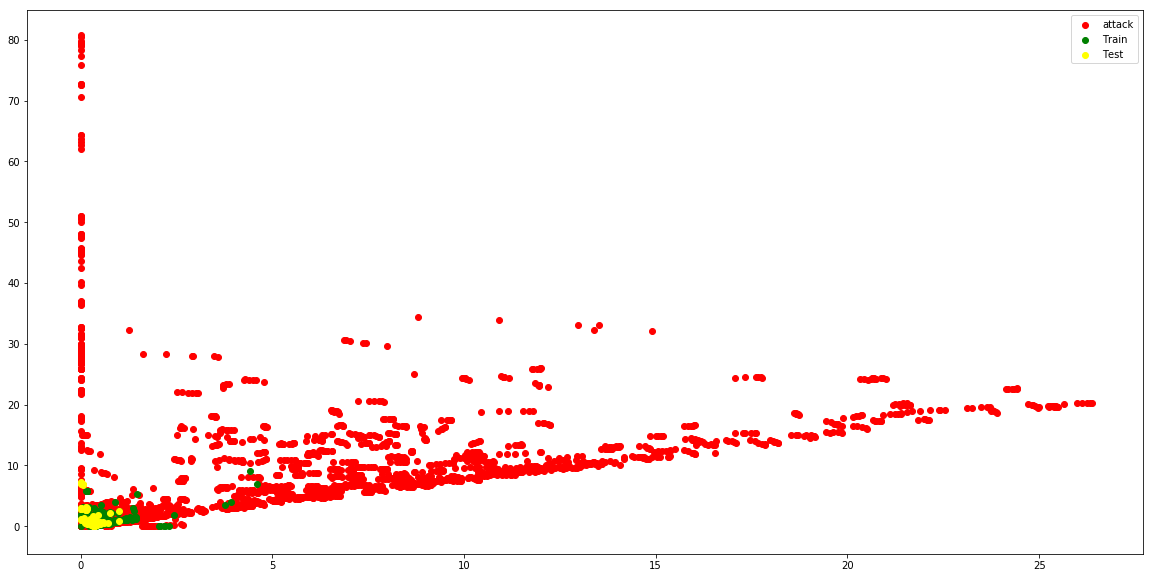

In [37]:
plt.figure(figsize=(20,10))
plt.scatter(x_attacks_red[:,0], x_attacks_red[:,1], color='red', label='attack')
plt.scatter(x_train_red[:,0], x_train_red[:,1], color='green', label='Train')
plt.scatter(x_test_red[:,0], x_test_red[:,1], color='yellow', label='Test')
plt.legend()

In [38]:
ae_svm_results = pd.DataFrame(columns=['gamma', 'nu', 'n_components', 'train_acc', 
                                    'test_acc', 'attack_acc', 'model', 'auc', 'f_beta'])

gammas = [x_train_red.shape[1], 2*x_train_red.shape[1], x_train_red.shape[1]/2, 'auto']                                 
for nu in nus:
    for gamma in gammas:
        classifier = svm.OneClassSVM(kernel='rbf',gamma=gamma, nu=nu, cache_size=5000)
        classifier.fit(X_reduced)
        y_pred_train = classifier.predict(X_reduced)
        y_pred_test = classifier.predict(test_reduced)
        y_pred_outliers = classifier.predict(attack_reduced)
        n_accurate_train = y_pred_train[y_pred_train == 1].size
        n_accurate_test = y_pred_test[y_pred_test == 1].size
        n_accurate_outliers = y_pred_outliers[y_pred_outliers == -1].size


        fpr, tpr, _ = metrics.roc_curve(np.concatenate([np.ones(y_pred_test.shape[0]),
                                                         -1*np.ones(y_pred_outliers.shape[0])]), 
                                          np.concatenate([y_pred_test, y_pred_outliers]) , pos_label=1)
        fb = metrics.fbeta_score(np.concatenate([np.ones(y_pred_test.shape[0]),
                                                         -1*np.ones(y_pred_outliers.shape[0])]), 
                                          np.concatenate([y_pred_test, y_pred_outliers]),beta=20 ,pos_label=1)

        ae_svm_results = svm_results.append({'nu': nu, 'gamma': gamma, 'n_components': n, 'train_acc': n_accurate_train/X_reduced.shape[0],
                       'test_acc': n_accurate_train/X_reduced.shape[0], 'attack_acc': n_accurate_outliers/attack_reduced.shape[0],
                       'model': 'ae-svm', 'auc': metrics.auc(fpr, tpr), 'f_beta': fb}, ignore_index=True)


In [39]:
ae_svm_results.sort_values('f_beta', ascending=False).head(10)

,gamma,nu,n_components,train_acc,test_acc,attack_acc,model,auc,f_beta,score
90,1,0.0010,2,0.968278,0.968278,0.689211,svm,0.823521,0.936214,0.000000
88,2,0.0010,2,0.945619,0.945619,0.721618,svm,0.830689,0.920767,1.667238
84,2,0.0100,2,0.957704,0.957704,0.715378,svm,0.824557,0.914461,1.673082
106,0.5,0.0010,1,0.942598,0.942598,0.313003,svm,0.635417,0.911207,0.000000
59,auto,0.0010,4,0.963746,0.963746,0.717995,svm,0.822853,0.908748,1.681741
75,auto,0.0010,3,0.971299,0.971299,0.704509,svm,0.816110,0.907853,1.675808
85,4,0.0100,2,0.938066,0.938066,0.767713,svm,0.844700,0.906154,1.705780
7,auto,0.0100,7,0.975831,0.975831,0.734098,svm,0.827892,0.903925,1.709929
31,auto,0.0001,6,0.950151,0.950151,0.728663,svm,0.825175,0.903565,1.678815
55,auto,0.0100,4,0.965257,0.965257,0.716787,svm,0.819237,0.902781,1.682044
